# Market Simulation

This notebook creates one file.
For a given number of market situations, each market situation is simulated with the same starting condition multiple times for a specified time horizon.
In the `demand_learning_data` file we save explanatory variables for market situations and whether there was a purchase in the current situation. We also create three graphs displaying a selected time period from our simulation.

** We create the output files for three different pricing setups:**
* _Setup 1 (S1):_  For the watched company we chose a random price between 0 and 15. For all the other companies, we chose a price between 5 and 15.
* _Setup 2 (S2):_ For each company we use the same pricing strategy:  
```min_competitor_price = min(prices_companies)
if min_competitor_price < 5:
    10
else:
    max(4.9, (min_competitor_price - 0.5))
```
* _Setup 3 (S3):_ For the first three companies we use the approach from Setup 2, except with different thresholds. The last two companies have a fixed price of either 11 or 13.

In [1]:
import random
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd

Set start values.

In [2]:
num_firm = 5                                                                # the number of firms which we simulate
time_horizon = 100                                                          
num_market_events = time_horizon + 100                                      # the maximum number of market events
mean_betw_customer_arrival = 1
num_customer_events = int(time_horizon / mean_betw_customer_arrival + 100)  # the maximum number of customer events
iter_diff_start = 100                                                       # how often to simulate with same start
iter_same_start = 1                                                         # how often to simulate with 
                                                                            # different start
watched_firm = 0
current_line = 0
setups = ["S1","S2","S3"]                                                   # set the names of different setups
random.seed(3819469)                                                        # set a random seed to 
                                                                            # always get comparable results

Set market start situation.

In [3]:
prices_firm = np.round(np.random.uniform(6,16, size = (iter_diff_start, num_firm)), decimals = 2)
qual_firm = np.round(np.random.uniform(0.5,5.5, size = (iter_diff_start, num_firm)))
rating_firm = np.round(np.random.uniform(90, 100, size = (iter_diff_start, num_firm)), decimals = 1)

Calculate all the necessary information for when firms adjusts their prices and how often they adjust their prices.  

In [4]:
time_betw_market_events_firm = np.random.uniform(0.8, 1.2, size = (iter_diff_start, iter_same_start, num_firm, num_market_events))

time_adjusts_firm = time_betw_market_events_firm

time_adjusts_firm[:,:,:,0] = np.random.uniform(0, 1, size = (iter_diff_start, iter_same_start, num_firm))

for d in range(iter_diff_start):
    for s in range(iter_same_start):
        for c in range(num_firm):
            for i in range(1, num_market_events):
                time_adjusts_firm[d,s,c,i] = time_adjusts_firm[d,s,c,i-1] + time_betw_market_events_firm[d,s,c,i]
                
price_adjusts_before_horizon = np.array(
    [[
            set([
                time_adjusts_firm[d,s].flatten()[i] 
                for i in range(len(time_adjusts_firm[d,s].flatten())) 
                if time_adjusts_firm[d,s].flatten()[i] < time_horizon])
            for s in range(iter_same_start)]
        for d in range(iter_diff_start)])
        
price_adjusts_before_horizon = np.array(
    [[
            [0] + sorted(price_adjusts_before_horizon[d,s]) + [time_horizon]
            for s in range(iter_same_start)]
        for d in range(iter_diff_start)])

num_price_adjusts_before_horizon = np.array(
    [[
            len(price_adjusts_before_horizon[d,s])
            for s in range(iter_same_start)]
        for d in range(iter_diff_start)])

firm_adjusting_at_time = np.array(
    [[[
                min(np.where(time_adjusts_firm[d,s]==price_adjusts_before_horizon[d,s][i])[0])
                if price_adjusts_before_horizon[d,s][i]!=time_horizon and i!=0 
                else -1  
                for i in range(num_price_adjusts_before_horizon[d,s])]
            for s in range(iter_same_start)]
        for d in range(iter_diff_start)])    

Calculate when customers will arrive and how they will score the quality and rating of all firms.

In [5]:
time_betw_customer_events = (mean_betw_customer_arrival * 
                             np.random.exponential(size = (iter_diff_start, iter_same_start, num_customer_events)))

time_customer_events = time_betw_customer_events

for d in range(iter_diff_start):
    for s in range(iter_same_start):
        for k in range(1, num_customer_events):
            time_customer_events[d,s,k] = time_customer_events[d,s,k-1] + time_betw_customer_events[d,s,k]
            
rand_customer_score_qual = np.random.uniform(0, 1, size = (iter_diff_start, iter_same_start, num_customer_events))

rand_customer_score_rating = np.random.uniform(0, 0.5, size = (iter_diff_start, iter_same_start, num_customer_events))

customer_score_qual_rating = np.array(
    [[[[
                    (rand_customer_score_qual[d,s,c]*qual_firm[d,k] +
                     rand_customer_score_rating[d,s,c]*(100-rating_firm[d,k]))
                    for k in range(num_firm)] 
                for c in range(num_customer_events)]
            for s in range(iter_same_start)]
        for d in range(iter_diff_start)])

Create variables for watched firm.

In [6]:
count_adjusts_watched_firm = np.array(
    [[
            sum([
                1 
                for i in range(num_price_adjusts_before_horizon[d,s])
                if firm_adjusting_at_time[d,s][i] == watched_firm]) + 1 
            for s in range(iter_same_start)]
        for d in range(iter_diff_start)])

time_adjusts_watched_firm = np.array(
    [[[
                price_adjusts_before_horizon[d,s][i] 
                for i in range(num_price_adjusts_before_horizon[d,s]) 
                if firm_adjusting_at_time[d,s][i] == watched_firm]
            for s in range(iter_same_start)] 
        for d in range(iter_diff_start)])

for d in range(iter_diff_start):
    for s in range(iter_same_start):
        time_adjusts_watched_firm[d,s].insert(0,0)
        time_adjusts_watched_firm[d,s].extend([time_horizon])

In [7]:
def price_if_smaller_else(price, price_threshold, min_price, prices_firm, c):
    return(
        price 
        if min([prices_firm[c] for firm in range(num_firm) if firm!=c]) < price_threshold 
        else round(
            min([
                    max(min_price, prices_firm[firm] - 0.5) for firm in range(num_firm) if firm != c])
            ,2))
s1 = {
        '0' : lambda prices_firm, c: round(random.uniform(0,15),2),
        '1' : lambda prices_firm, c: round(random.uniform(5,15),2),
        '2' : lambda prices_firm, c: round(random.uniform(5,15),2),
        '3' : lambda prices_firm, c: round(random.uniform(5,15),2),
        '4' : lambda prices_firm, c: round(random.uniform(5,15),2)
    }

s2 = {
        '0' : lambda prices_firm, c: price_if_smaller_else(10,5,4.9,prices_firm,c),
        '1' : lambda prices_firm, c: price_if_smaller_else(10,5,4.9,prices_firm,c),
        '2' : lambda prices_firm, c: price_if_smaller_else(10,5,4.9,prices_firm,c),
        '3' : lambda prices_firm, c: price_if_smaller_else(10,5,4.9,prices_firm,c),
        '4' : lambda prices_firm, c: price_if_smaller_else(10,5,4.9,prices_firm,c)
    }

s3 = {
        '0' : lambda prices_firm, c: price_if_smaller_else(10,5,4.9,prices_firm,c),
        '1' : lambda prices_firm, c: price_if_smaller_else(9,4,3.9,prices_firm,c),
        '2' : lambda prices_firm, c: price_if_smaller_else(12,6,5.9,prices_firm,c),
        '3' : lambda prices_firm, c: 11,
        '4' : lambda prices_firm, c: 13
    }

In [8]:
def explanatory_vars(d, s, explanatory_var, count_adjust, setup):
    return {
        '0' : 1,
        '1' : price_ranks_firm[setup,d,s][count_adjust],
        '2' : 1 if price_ranks_firm[setup,d,s][count_adjust]==1 else 0,
        '3' : qual_rank_firm[d],
        '4' : rating_ranks[d,watched_firm],
        '5' : prices_tracked[setup,d,s][count_adjust][watched_firm],
        '6' : prices_tracked[setup,d,s][count_adjust][watched_firm] - min([prices_tracked[setup,d,s][count_adjust][j] for j in range(num_firm) if j!=watched_firm]) if num_firm > 1 else 0,
        '7' : qual_firm[d,watched_firm],
        '8' : rating_firm[d,watched_firm],
        '9' : 15 - (prices_tracked[setup,d,s][count_adjust][watched_firm] + 
                    0.5*qual_firm[d,watched_firm] + 
                    0.25*(100-rating_firm[d,watched_firm])) 
        if((prices_tracked[setup,d,s][count_adjust][watched_firm] +
            0.5*qual_firm[d,watched_firm] +
            0.25*(100-rating_firm[d,watched_firm])) 
           < min([
               prices_tracked[setup,d,s][count_adjust][j] +
                  0.5*qual_firm[d,j] +
                  0.25*(100-rating_firm[d,j]) 
               for j in range(num_firm) 
               if j!= watched_firm]))
        else 0,
    }[str(explanatory_var)]

def calc_prices(prices_firm_adjust, adjusting_firm, setup):
    prices_firm_adjust = np.array(prices_firm_adjust)
    for comp in range(num_firm):
        prices_firm_adjust[0:, comp] = setup[str(comp)](prices_firm_adjust[0],comp)
    #weird indexing because there are actually no price adjustments at time 0 nor on the price horizon
    for i in range(1,len(prices_firm_adjust)-1):        
        prices_firm_adjust[i:,adjusting_firm[i]] = setup[str(adjusting_firm[i])](prices_firm_adjust[i-1],adjusting_firm[i])
    return prices_firm_adjust

As we don't want to know what happens after or on the time horizon, we will always substract 1 when using the value num_price_adjusts_before_horizon in the following code.

In [9]:
# get all the customers that appear between market events, so we don't always have to iterate through each customer
gen = np.array(
    [[[[
                    x 
                    for x in range(num_customer_events) 
                    if price_adjusts_before_horizon[d,s][i]< time_customer_events[d,s][x]<= price_adjusts_before_horizon[d,s][i+1]] 
                for i in range(num_price_adjusts_before_horizon[d,s] - 1)] 
            for s in range(iter_same_start)] 
        for d in range(iter_diff_start)])

Calculate the prices adjustments for each firm in the time horizon.

In [10]:
prices_firm_adjust = np.array(
    [[[[
                    prices_firm[d,k]  
                    for k in range(num_firm)]
                for _ in range(num_price_adjusts_before_horizon[d,s] - 1)]
            for s in range(iter_same_start)] 
        for d in range(iter_diff_start)])

prices_firm_adjust = np.array(
    [[[
                np.array(calc_prices(prices_firm_adjust[d,s], firm_adjusting_at_time[d,s], globals()["s{}".format(setup+1)])) 
                for s in range(iter_same_start)] 
            for d in range(iter_diff_start)]
        for setup in range(len(setups))])

Simulate the customer by completing the score using the current prices of each firm and then calculating a decision for each customer.

In [11]:
customer_score = np.array(
    [[[[[[
                            customer_score_qual_rating[d,s,c,k]+prices_firm_adjust[setup,d,s][i,k] 
                            for k in range(num_firm)] 
                        for c in gen[d,s][i]]
                    for i in range(num_price_adjusts_before_horizon[d,s] - 1)]
                for s in range(iter_same_start)]
            for d in range(iter_diff_start)]
        for setup in range(len(setups))])

customer_decision = np.array(
    [[[[[
                        np.argmin(customer_score[setup,d,s][i][c]) 
                        if min(customer_score[setup,d,s][i][c])< random.uniform(5,15) 
                        else -1 
                        for c in range(len(gen[d,s][i]))] 
                    for i in range(num_price_adjusts_before_horizon[d,s] - 1)]
                for s in range(iter_same_start)]
            for d in range(iter_diff_start)]
        for setup in range(len(setups))])

Track data that is used to create further graphs and save them.

In [12]:
accumulated_profit = np.array(
    [[[[
                    sum([
                        sum([
                            prices_firm_adjust[setup,d,s][i,k] 
                            if customer_decision[setup,d,s][i][c]==k 
                            else 0 
                            for c in range(len(gen[d,s][i]))]) 
                        for i in range(num_price_adjusts_before_horizon[d,s] - 1)])
                    for k in range(num_firm)]
                for s in range(iter_same_start)]
            for d in range(iter_diff_start)]
        for setup in range(len(setups))])

prices_tracked = np.array(
    [[[[[
                        prices_firm_adjust[setup,d,s][i,k] 
                        for k in range(num_firm) 
                        if firm_adjusting_at_time[d,s][i]==watched_firm or price_adjusts_before_horizon[d,s][i]==0] 
                    for i in range(num_price_adjusts_before_horizon[d,s] - 1)]
                for s in range(iter_same_start)]
            for d in range(iter_diff_start)]
        for setup in range(len(setups))])

prices_tracked = np.array(
    [[[[
                    x 
                    for x in prices_tracked[setup,d,s] 
                    if x != []] 
                for s in range(iter_same_start)]
            for d in range(iter_diff_start)]
        for setup in range(len(setups))])

index_time_adjusts = np.array(
    [[[[[
                        x 
                        for x in range(num_price_adjusts_before_horizon[d,s]) 
                        if price_adjusts_before_horizon[d,s][x]==time_adjusts_watched_firm[d,s][i]] 
                    for i in range(count_adjusts_watched_firm[d,s] + 1)]
                for s in range(iter_same_start)]
            for d in range(iter_diff_start)]
        for setup in range(len(setups))])

sales_betw_adjusts = np.array(
    [[[[
                    sum([
                        sum([
                            1 
                            for c in range(len(gen[d,s][j])) 
                            if customer_decision[setup,d,s][j][c]==watched_firm])
                        for j in range(num_price_adjusts_before_horizon[d,s]) 
                        if j>=index_time_adjusts[setup,d,s][i][0] and j<index_time_adjusts[setup,d,s][i+1][0]]) 
                    for i in range(count_adjusts_watched_firm[d,s])]
                for s in range(iter_same_start)]
            for d in range(iter_diff_start)]
        for setup in range(len(setups))])

price_ranks_firm = np.array(
    [[[[
                  1 +  
                  sum([
                      1 
                      for i in range(num_firm) 
                      if prices_tracked[setup,d,s][j][watched_firm]> prices_tracked[setup,d,s][j][i] and i!=watched_firm]) 
                  +
                  sum([
                      1 
                      for i in range(num_firm) 
                      if prices_tracked[setup,d,s][j][watched_firm]== prices_tracked[setup,d,s][j][i] and i!=watched_firm])/2
                  for j in range(count_adjusts_watched_firm[d,s])]
                for s in range(iter_same_start)] 
            for d in range(iter_diff_start)]
        for setup in range(len(setups))])

qual_rank_firm = np.array(
    [
          1 +  
          sum([
              1 
              for i in range(num_firm) 
              if qual_firm[d,watched_firm]> qual_firm[d,i] and i!=watched_firm]) 
          +
          sum([
              1 
              for i in range(num_firm) 
              if qual_firm[d,watched_firm]== qual_firm[d,i] and i!=watched_firm])/2
          for d in range(iter_diff_start)])

rating_ranks = np.array(
    [[
          1 +  
          sum([
              1 
              for i in range(num_firm) 
              if rating_firm[d,j]> rating_firm[d,i] and i!=j]) 
          +
          sum([
              1 
              for i in range(num_firm) 
              if rating_firm[d,j]== rating_firm[d,i] and i!=j])/2
          for j in range(num_firm)] 
        for d in range(iter_diff_start)])

for setup in range(len(setups)):
    current_line = 0
    with open('demand_learning_data_{}.csv'.format(setups[setup]), 'w') as file:
        writer = csv.writer(file, delimiter='\t')
        for d in range(iter_diff_start):
            for s in range(iter_same_start):
                for w in range(count_adjusts_watched_firm[d,s]):
                    current_line = current_line +1
                    line = list([current_line])
                    for k in range(1,10):
                        line.append(explanatory_vars(d, s, k, w, setup))
                    line.append(sales_betw_adjusts[setup,d,s][w])
                    writer.writerow(line)

Track data for graph.

In [13]:
arrival_out = np.array(
    [[[
                np.array([
                    (time_customer_events[d,s,x],  x) 
                    for x in gen[d,s][i]]) 
                for i in range(num_price_adjusts_before_horizon[d,s] - 1)]
            for s in range(iter_same_start)] 
        for d in range(iter_diff_start)])

buying_out = np.array(
    [[[[[
                        [time_customer_events[d,s][gen[d,s][i][c]], prices_firm_adjust[setup,d,s][i,customer_decision[setup,d,s][i][c]], gen[d,s][i][c], customer_decision[setup,d,s][i][c]]
                        for c in range(len(gen[d,s][i])) 
                        if customer_decision[setup,d,s][i][c]!=-1] 
                    for i in range(num_price_adjusts_before_horizon[d,s] - 1)] 
                for s in range(iter_same_start)]
            for d in range(iter_diff_start)]
        for setup in range(len(setups))])

traject_out = np.array(
    [[[[[
                        [prices_firm_adjust[setup,d,s][i,k], price_adjusts_before_horizon[d,s][i] ,k]
                        for k in range(num_firm)] 
                    for i in range(num_price_adjusts_before_horizon[d,s] - 1)] 
                for s in range(iter_same_start)]
            for d in range(iter_diff_start)]
        for setup in range(len(setups))])

Illusetupes examples of price trajectories over time as well as the arrival of interested (indicated by vertical bars on the x-axis) and buying customers (indicated by dots) in case of K=5.
Note, due to different qualities and ratings of competitors customers do not always choose the cheapest competitor.

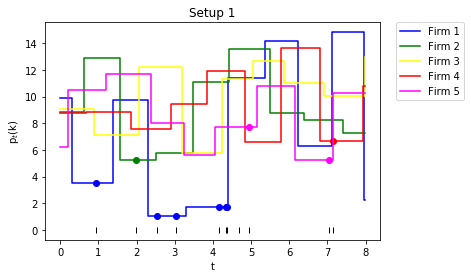

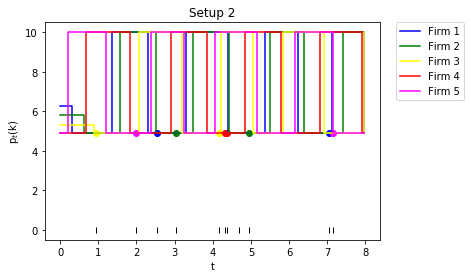

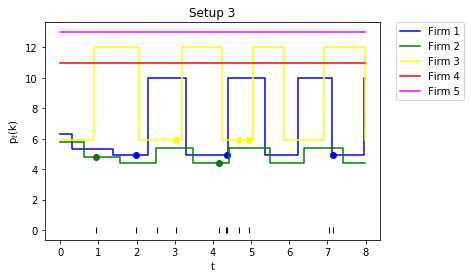

In [14]:
last_time = 8
adjustments = [t for t in range(num_price_adjusts_before_horizon[0,0] - 1) if traject_out[0,0,0][t][0][1]<last_time]
colors = ["blue","green","yellow","red","magenta"]
firms = range(num_firm)
arrivals = np.concatenate(np.array([arrival_out[0,0][t] for t in adjustments if arrival_out[0,0][t].size]).squeeze())
if arrivals.ndim == 1:
    arrivals = (np.array([arrival_out[0,0][t] for t in adjustments if arrival_out[0,0][t].size]).squeeze())
arrivals = np.array([arrival for arrival in arrivals if arrival[0]<last_time])
for setup in range(len(setups)):
    for color, firm in zip(colors, firms):
        plt.step([traject_out[setup,0,0][t][0][1] for t in adjustments], [traject_out[setup,0,0][t][firm][0] for t in adjustments], c = color, label='Firm {}'.format(firm+1), where="post")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    buying_data = np.concatenate([x for x in [buying_out[setup,0,0][t] for t in adjustments] if x != []])
    buying_data = np.array([buying for buying in buying_data if buying[0]<last_time])
    for color, firm in zip(colors, firms):
        buying_data_firm = np.array([buying_data[x] for x in range(len(buying_data)) if buying_data[x,3]==firm])
        if len(buying_data_firm>0):
            plt.scatter(buying_data_firm[:,0] ,buying_data_firm[:,1], c = color)
    plt.plot(arrivals[:,0],[0 for _ in arrivals[:,0]],'k|')
    plt.xlabel('t')
    plt.ylabel('p$_t$(k)')
    plt.title('Setup {}'.format(setup+1))
    plt.show()